# INTRODUCTION

You don't need to fully understand how to program in Python in order to use this notebook. The most relevant cells are tagged with ALL CAPS:

* CONFIGURATION - YAML FILE (Import OCLC credentials)

* EDIT THIS CELL (start and end dates)

* GET NEW TITLES (the API function - it takes a while!)

* EDA (Exploratory Data Analysis in a pandas DataFrame)

* EXPORT (put the data in an Excel file)


Just change the dates to the date range you want to get data from (1 month max recommended.) Then click the "fast-forward" button at the top of the page to "Restart the kernel and run all cells".

REMINDER: The dates must be in "YYYY-MM-DD" format. The code will not function correctly if they are formatted otherwise.

The data will be exported as a .xlsx file.

The whole script takes approximately ~15-20 minutes to run (for ~30000 titles) on a TCCS-issued Dell laptop with an Intel vPRO i5 processor. Your mileage may vary as far as total time goes, but the process of pulling the records from the API (the `get_new_titles()` function) is the portion of this script that will the most time.

# Accessing the OCLC New Titles APIs with Python

Key concepts:
* APIs
* Functions
    * Positional Arguments
    * Keyword Arguments
    * Recursive Functions
* Python Datatypes and Objects
    * Container Objects
    * Strings
* JSON Data
    * Nested Data
    * Dictionary Objects
* Pandas DataFrames
    * Populating columns 
* For & While Loops
* Conditional Statements
* Try-Except Blocks

# CONFIGURATION - YAML FILE

OCLC's APIs are accessible by means of WSKeys, which may be found on OCLC's [developer network page](https://www.oclc.org/developer/home.en.html). Clicking on "Manage your API keys" will take you to the WorldCat WSKEY page, where by entering the three-letter institutional code for the Claremont Colleges (**HDC**), you will be provided with links to our individual API keys.

You have been provided with a YAML file that contains empty fields for you to copy-paste the credentials from the New Titles WSKey page.

Go to the WSKey Management page for the New Titles API, then copy the Client ID, then paste into the YAML file under the field "key". Then do the same for "secret".

The config_NT.yml file will let you consolidate the credentials necessary to access the New Titles API. These will let us obtain a token to use the API.

Your YAML file will look like this:

![title](YAML.png)

Replace "KEY" with the Client ID key, and "SECRET" with the Secret.

## What is YAML?

What YAML stands for has changed over time, originally standing for "Yet Another Markup Language". Since its creation, it has been given more capabilities than a typical markup language, particularly in terms of data serialization. 

Consequently, YAML is now a recursive acronym for "YAML Ain't Markup Language".

YAML performs a similar function to JSON, but is a little easier to look at.

In [1]:
import yaml

In [2]:
# access config file data
with open('config_NT.yml', 'r') as file:
    config = yaml.safe_load(file)

In [3]:
baseUrl = config.get('baseUrl')

In [4]:
baseUrl

'https://discovery.api.oclc.org'

The next cell assigns the variables `start_date` and `end_date` for querying the OCLC New Titles API. 

# EDIT THIS CELL:

In [5]:
################################################################################
################################################################################

start_date = '2024-06-01'
end_date = '2024-06-30'

################################################################################
################################################################################

# Imports

This block of imports is the de facto standard set for nearly any Jupyter notebook that deals with analysis or visualiation of data. These libraries are used so commonly, and functions from within them are called so frequently, that an alias is used for them. Numpy is `np`, Pandas is `pd`, and Matplotlib's Pyplot module is `plt`.

In [6]:
#Python Data Science standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The [Python Standard Library](https://docs.python.org/3/library/index.html) includes support for the JSON file format, but the [json module](https://docs.python.org/3/library/json.html) still needs to be explicitly imported. Additionally, [PyYAML](https://pyyaml.org/) (module name: yaml) provides support for YAML files.

[Datetime](https://docs.python.org/3/library/datetime.html) handles time information in various formats in Python, whether it's in [Unix Epoch time](https://en.wikipedia.org/wiki/Unix_time) as a timestamp, as a proprietary DateTime object, or in more easily human-readable formats.

[Collections](https://docs.python.org/3/library/collections.html) is a module that extends Python's existing container datatypes (`set`, `list`, `dict`, `tuple`) with more specialized container datatypes. In this notebook, we will only be using this for purposes of identification.

The [requests](https://requests.readthedocs.io/en/latest/) library is the main library in Python for handling APIs. [Open Authorization](https://oauth.net/2/) is a protocol for authorization when logging in to various servers. Python's [oauthlib](https://github.com/oauthlib/oauthlib) package supports this protocol. The [requests_oauthlib](https://pypi.org/project/requests-oauthlib/) module is there to integrate these so they may be used together.

In [7]:
# JSON
import json

# Datetime
# More than one module may be imported from the same package
# at the same time, using commas:
from datetime import date, datetime, timedelta

# Collections
# If an item is in a subdirectory of a package, it may be imported
# using the following syntax:
from collections.abc import Iterable, Container

# Open Authorization
from oauthlib.oauth2 import BackendApplicationClient
from oauthlib.oauth2.rfc6749.errors import TokenExpiredError

# Requests
import requests
from requests.auth import HTTPBasicAuth

#OAuthlib authentication support for Requests
from requests_oauthlib import OAuth2Session


Most websites' APIs will return data in the form of JSON data, but sometimes data will be returned in other formats, such as in the form of .csv or .xml files. In those cases, other protocols must be used for parsing the returned data.

## Getting a Token for OCLC - Functions, Parameters, Return

This function takes the credentials from config_NT.yml and passes them to various imported classes (`HTTPBasicAuth`, `BackendApplicationClient`, and `OAuth2Session`) to obtain a token that grants access to the API. You don't need to know exactly how this works, other than that it passes your OCLC WSKey credentials to the OCLC URL to get a temporary pass for permission to access a database.

In [8]:
def get_token(config):
    scope = config.get('scope')
    auth = HTTPBasicAuth(config.get('key'), config.get('secret'))
    client = BackendApplicationClient(client_id=config.get('key'), scope=scope)
    oauth = OAuth2Session(client=client)
    token = oauth.fetch_token(token_url=config.get('tokenUrl'), auth=auth)
    return scope, auth, client, oauth, token

In [9]:
#Let's look at the response we get when we obtain a token:
scope, auth, client, oauth, token = get_token(config)
token

{'access_token': 'tk_4ukoA1AVxEcp5ipkALvJz8tO9rDjxSvoDdSe',
 'expires_at': 1721760489.0834913,
 'authenticating_institution_id': '5640',
 'scope': ['new-titles'],
 'principalID': '',
 'context_institution_id': '5640',
 'scopes': 'new-titles',
 'token_type': 'bearer',
 'expires_in': 1199,
 'principalIDNS': ''}

The token is valid for 1199 seconds, just shy of 20 minutes. The institution id fields both contain 5640, TCCL's unique identifier in OCLC's system.

In [10]:
token_start = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
token_end = datetime.fromtimestamp(token['expires_at']).strftime('%Y-%m-%d %H:%M:%S')

print(token_start)
print(token_end)

2024-07-23 11:28:10
2024-07-23 11:48:09


## URLs and API Endpoints

URLs (Uniform Resource Locators) are text strings that contain information necessary to point to a specific web pages. They're often called "addresses". 

An API endpoint is the specific URL that functions as the actual access point for applications to communicate with one another.

# Querying the New Titles API

Let's try writing a function that finds all the new titles within a specified date range.

We can reference the [New Titles API](https://developer.api.oclc.org/new-titles-api) to find components of the URL we want to use to get our specific query (our API endpoint).

In [11]:
def get_oclc_data(start, end, config):
    scope, auth, client, oauth, token = get_token(config)

    response = oauth.get(
        baseUrl + '/new-titles/?heldBySymbol=HDC&dateHoldingSetStart='
        + str(start) + '&dateHoldingSetEnd=' + str(end),
        headers={"Accept":"application/json"}
    )
    
    data = response.json()
    return data

test_data = get_oclc_data(start_date, end_date, config)

So, what did we get back?

In [12]:
type(test_data)

dict

In [13]:
#The returned JSON data has three fields:
test_data.keys()

dict_keys(['numberOfRecords', 'briefRecords', 'searchFacets'])

In [14]:
test_data['numberOfRecords']

19803

How many new titles were actually retrieved?

In [15]:
len(test_data['briefRecords'])

10

10 is sure smaller than 19803. Something isn't working the way we want it to.

In [16]:
test_data['searchFacets']

[{'index': 'mt',
  'facetType': 'content',
  'values': [{'value': 'nonFic', 'count': 19688},
   {'value': 'bio', 'count': 330},
   {'value': 'fic', 'count': 115}]}]

### Check the first entry (JSON Format)

The documentation includes the schema for the JSON files that will be returned. We can use this to inform our data extraction process, but it will be less of a headache if we use dedicated functions to extract fields.

![title](NewTitlesResultSchema.png)

Not all entries have the same number of fields, but this gives us a general idea of what to expect. We'll revisit this once we've actually gotten all the data we want.

In [17]:
test_data['briefRecords'][0]

{'oclcNumber': '1085293558',
 'title': 'The statutes of Illinois : embracing all of the general laws of the state, in force December 1, 1857, with marginal notes, showing the contents of each section, and a reference to the decisions of the Supreme Court upon the construction of each statute',
 'mergedOclcNumbers': ['680529770', '1021272533', '1091068810'],
 'titleInfo': {'text': 'The statutes of Illinois : embracing all of the general laws of the state, in force December 1, 1857, with marginal notes, showing the contents of each section, and a reference to the decisions of the Supreme Court upon the construction of each statute'},
 'creator': 'Illinois',
 'contributors': [{'nonPersonName': {'text': 'Illinois'}, 'isPrimary': True},
  {'firstName': {'text': 'Samuel Hubbel'},
   'secondName': {'text': 'Treat'},
   'isPrimary': False,
   'relatorCodes': ['com'],
   'contributorNotes': {'date': ['1811-1887,']}},
  {'firstName': {'text': 'Walter B.'},
   'secondName': {'text': 'Scates'},
  

## How to Deal with the Limitations of APIs:

Most APIs have their own proprietary syntax, specifications for the parameters that get passed to them, and limits on what can be retrieved from them.

We're not getting all the results because the New Titles API only lets us retrieve 50 records at a time.

Given this liimitation (and assuming we set `&limit=50` instead of the default 10), we must find a way to iterate through the records in the OCLC database, and to combine chunks of data into a cohesive whole as we retrieve them. 

The API lets us pass in an "offset" string as part of the URL (i.e.: `&offset=50`), which tells the query to begin at a specified index.

We need to keep track of how many records we have retrieved; partly because it helps observe our function's progress, but also because there is a small number of records that the database tells us are there, but that we cannot retrieve. 

The number of titles is in flux and may return different totals when run multiple times. Though we cannot be precisely certain of the cause of this, our assumption is that it is due to titles being removed after having been added, and leaving an empty space before all the titles are periodically consolidated. We have tried selecting other values for `&limit=` and the loss still occurred.

Our token is valid for 20 minutes, which *should* be long enough to get all the records in a month, but we also want to be able to extend our session if we are pulling data from within a particularly long timeframe.

With all that in mind, let's define a function that will return as many New Titles records as are retrievable within a date range.

# `get_new_titles()` Function

We've covered a lot of different concepts so far. These are all the topics from the Slides that will be critical for our `get_new_titles()` function to work as desired:

* Variables

* Functions

* Keyword Arguments

* Strings

* Container Objects

* Methods

* While Loops

* Try-Except Blocks

* If-(Elif)-Else Blocks

When designing a function, it is often a good idea to write a block of instructions in more-or-less human-readable sentences (using some terms specific to the language if necessary). This is called "pseudocode", and it can be very helpful for conceptualizing what a function does, especially the more abstract it becomes or the more moving parts it contains.

Pseudocode isn't strictly necessary, but it can be a helpful beat-by-beat visualization of what the code is *supposed* to do, sort of like an outline for an essay, or a story-board for an animation.

```
def get_new_titles(start, end, config, kwargs):
    get_token(config)
    data = dictionary with empty container objects in it
    initialized numerical parameters for URL construction and loop functionality
    initialized string parameters for URL construction
    url (string components)
    while loop: (condition: length of response is not zero)
        try:
            set "offset" = 0, increase by 50 every iterations
            insert numerical parameters into URL string
            query the API using oauth.get()
            parse the response as a JSON object
            extend data dictionary's container objects with contents of response
            increment tally of records retrieved
            print out progress
            update response_len variable (will end while loop if == 0)
        except TokenExpiredError:
            get_token(config) again to refresh 20-minute timer
    return data
```

In [18]:
################################################################################

def get_new_titles(start, end, config, limit=50, response_len=50):

    """
    get_new_titles() accepts start and end date in YYYY-MM-DD format
    (see https://developer.api.oclc.org/new-titles-api)
    limit=50 and response_len=50 reflect the limit of 50 records 
    returned per query

    response_len - this variable is initialized to 50 so the
    function's "while" statement will work on the first iteration.

    limit - this variable is initialized to 50. Value range: 0 - 50.
    """
    
    print(start + " to " + end)
    
    # Get token using our get_token() function:
    scope, auth, client, oauth, token = get_token(config)

    # Define containers for incoming JSON data:
    data = {
        'numberOfRecords':[], 'briefRecords':[], 'searchFacets':[]
    }

    # Initialize some variables to determine when to stop
    num_records = 0
    items_retrieved = 0
    offset = 0

    # get API parameters as segments to add to URL string:
    heldby = '?heldBySymbol=HDC'
    startstr = '&dateHoldingSetStart=' + start
    endstr = '&dateHoldingSetEnd=' + end
        
    # extend baseUrl with extra API parameters
    url = baseUrl + '/new-titles/' + heldby + startstr + endstr

    # Because we don't really know how many records there are,
    # we use a while loop instead of a for loop.
    # start at the beginning, go in chunks based on limit
    while response_len != 0:
        try:
            offsetstr = '&offset=' + str(offset)
            limitstr = '&limit=' + str(limit)
            response = oauth.get(
                url + offsetstr + limitstr,
                headers={"Accept":"application/json"}
            )

            # "segment" is the JSON response
            segment = response.json()

            # .get() ensures that the script will not fail if the field
            # does not exist in a particular entry
            data['briefRecords'].extend(segment.get('briefRecords',[]))
            data['numberOfRecords'].append(segment.get('numberOfRecords'))

            # Start at 0, then add 50 with every iteration.
            offset += limit

            # during the first iteration, replace initial 0 with the
            # current returned value for the value in the
            # 'numberOfRecords' field
            if num_records == 0:
                num_records = segment.get('numberOfRecords',0)

            # Keep a running total of *actual* number of items retrieved.
            items_retrieved += len(segment.get('briefRecords',[]))
            print('Items Retrieved: ', items_retrieved, 'of', num_records)

            # if no records are retrieved out of a 50-item chunk,
            # end the loop. Otherwise, proceed.
            if segment.get('numberOfRecords',0) == 0:
                response_len = 0
            else:
                response_len = len(segment.get('briefRecords',[]))

        # This will likely not be necessary un less a very large
        # date selection is chosen:
        except TokenExpiredError:
            print('Refreshing Token')
            scope, auth, client, oauth, token = get_token(config)
            
    return data

# GET NEW TITLES

This will retrieve all new titles in the selected date range (see the first code cell of the notebook). 

In [19]:
new_titles = get_new_titles(start_date, end_date, config)

2024-06-01 to 2024-06-30
Items Retrieved:  50 of 19803
Items Retrieved:  100 of 19803
Items Retrieved:  150 of 19803
Items Retrieved:  199 of 19803
Items Retrieved:  249 of 19803
Items Retrieved:  299 of 19803
Items Retrieved:  349 of 19803
Items Retrieved:  398 of 19803
Items Retrieved:  446 of 19803
Items Retrieved:  494 of 19803
Items Retrieved:  543 of 19803
Items Retrieved:  591 of 19803
Items Retrieved:  640 of 19803
Items Retrieved:  687 of 19803
Items Retrieved:  736 of 19803
Items Retrieved:  786 of 19803
Items Retrieved:  836 of 19803
Items Retrieved:  885 of 19803
Items Retrieved:  935 of 19803
Items Retrieved:  985 of 19803
Items Retrieved:  1035 of 19803
Items Retrieved:  1085 of 19803
Items Retrieved:  1135 of 19803
Items Retrieved:  1185 of 19803
Items Retrieved:  1235 of 19803
Items Retrieved:  1285 of 19803
Items Retrieved:  1335 of 19803
Items Retrieved:  1385 of 19803
Items Retrieved:  1431 of 19803
Items Retrieved:  1481 of 19803
Items Retrieved:  1524 of 19803
Item

In [20]:
new_titles.keys()

dict_keys(['numberOfRecords', 'briefRecords', 'searchFacets'])

In [21]:
new_titles['numberOfRecords'][0]

19803

In [22]:
len(new_titles['briefRecords'])

19491

They're still not equal, but that's a lot closer.

In [23]:
len(new_titles['briefRecords']) / new_titles['numberOfRecords'][0]

0.9842448113922133

## Missingess

In [24]:
1 - len(new_titles['briefRecords']) / new_titles['numberOfRecords'][0]

0.015755188607786685

## JSON Data

In [25]:
# This lets us look at the surface-level fields in the JSON data to see
# what kind of objects each field contains:
# ANSI escape codes added for color in the print statement

fields = {}

for title in new_titles['briefRecords']:
    for field in title.keys():
        if field not in fields.keys():
            fields[field] = []
            if type(title[field]) == list:
                #Green text
                prefix = "\033[32m"
                suffix = "\033[0m"
            elif type(title[field]) == dict:
                #Blue text
                prefix = "\033[34m"
                suffix = "\033[0m"
            else:
                prefix = ''
                suffix = ''
            print(
                field+':', prefix+str(type(title[field]))+suffix
            )

oclcNumber: <class 'str'>
title: <class 'str'>
mergedOclcNumbers: <class 'list'>
titleInfo: <class 'dict'>
creator: <class 'str'>
contributors: <class 'list'>
date: <class 'str'>
machineReadableDate: <class 'str'>
language: <class 'str'>
generalFormat: <class 'str'>
specificFormat: <class 'str'>
publisher: <class 'str'>
publicationPlace: <class 'str'>
subjectsText: <class 'list'>
institutionHoldingIndicators: <class 'list'>
peerReviewed: <class 'str'>
citationUrl: <class 'str'>
openAccessLinks: <class 'list'>
isbns: <class 'list'>
series: <class 'str'>
doi: <class 'str'>
summariesText: <class 'list'>
seriesVolumes: <class 'list'>
edition: <class 'str'>
source: <class 'list'>
issns: <class 'list'>
incorrectIssns: <class 'list'>
filmInfo: <class 'str'>
abstractsText: <class 'list'>
dissertationInfo: <class 'dict'>
digitalObjectInfo: <class 'dict'>
sourceIssns: <class 'list'>


Although it's clear that some of our data has clear endpoints where the field just contains a string (black text), there are several fields that contain lists (in green) or dictionaries (in blue) of objects. We will need to parse these if we want to extract all the data in the JSON source.

In [26]:
new_titles['briefRecords'][0]

{'oclcNumber': '1085293558',
 'title': 'The statutes of Illinois : embracing all of the general laws of the state, in force December 1, 1857, with marginal notes, showing the contents of each section, and a reference to the decisions of the Supreme Court upon the construction of each statute',
 'mergedOclcNumbers': ['680529770', '1021272533', '1091068810'],
 'titleInfo': {'text': 'The statutes of Illinois : embracing all of the general laws of the state, in force December 1, 1857, with marginal notes, showing the contents of each section, and a reference to the decisions of the Supreme Court upon the construction of each statute'},
 'creator': 'Illinois',
 'contributors': [{'nonPersonName': {'text': 'Illinois'}, 'isPrimary': True},
  {'firstName': {'text': 'Samuel Hubbel'},
   'secondName': {'text': 'Treat'},
   'isPrimary': False,
   'relatorCodes': ['com'],
   'contributorNotes': {'date': ['1811-1887,']}},
  {'firstName': {'text': 'Walter B.'},
   'secondName': {'text': 'Scates'},
  

In [27]:
new_titles['briefRecords'][0]['contributors']

[{'nonPersonName': {'text': 'Illinois'}, 'isPrimary': True},
 {'firstName': {'text': 'Samuel Hubbel'},
  'secondName': {'text': 'Treat'},
  'isPrimary': False,
  'relatorCodes': ['com'],
  'contributorNotes': {'date': ['1811-1887,']}},
 {'firstName': {'text': 'Walter B.'},
  'secondName': {'text': 'Scates'},
  'isPrimary': False,
  'relatorCodes': ['com'],
  'contributorNotes': {'date': ['1808-1887,']}},
 {'firstName': {'text': 'Robert S.'},
  'secondName': {'text': 'Blackwell'},
  'isPrimary': False,
  'relatorCodes': ['com'],
  'contributorNotes': {'date': ['1823-1863,']}},
 {'nonPersonName': {'text': 'Illinois Supreme Court'}, 'isPrimary': False}]

In [28]:
new_titles.keys()

dict_keys(['numberOfRecords', 'briefRecords', 'searchFacets'])

## How Many Fields?

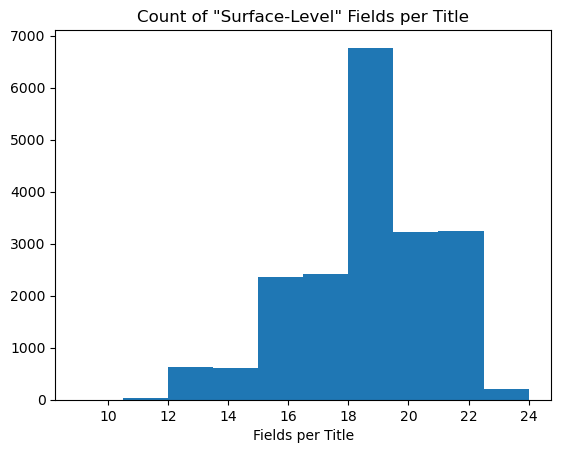

In [29]:
numfields = []

for item in new_titles['briefRecords']:
    numfields.append(len(item))
    
plt.hist(numfields)
plt.title('Count of "Surface-Level" Fields per Title')
plt.xlabel('Fields per Title')
plt.show()

We can see from this histogram that not every item in the JSON data has the same number of surface-level fields; some titles have more than one author, others lack citation URLs. We want to be prepared for the maximum number of fields (at least for these top-level fields) when converting this data into a tabular format.

One of the disadvantages of JSON data is that can be difficult know whether all possible fields are accounted for in a subset of all the data. The New Titles API goes over the schema for the returned JSON file, but it's not easy to extract the schema from their page for our purpuses, so we'll instead accomplish it by using functions in Python.

## Recursive Functions

Of all the cells in this notebook, the next two may be the most difficult to understand intuitively. The functions `iterate_nested_json()` and `flatten()` each have two features that set them apart from other functions. First, they call themselves recursively. Second, they pass data by means of `yield` rather than `return`. 

Recursive functions are functions that either directly or indirectly call themselves as a subprocess. If a recursive function takes arguments as inputs, it must be structured such that it can pass on a subset of its top-level inputs and pass it on to another instance of itself as a lower-level process.

In the case of `iterate_nested_json()`, the function checks what kind of object is being passed as an argument, then behaves differently depending on what the check reveals. If the argument is a dictionary, it will proceed to call itself on every key-value pair in that dictionary. If the item is a list, it will call itself on each element of that list. If the object at the end of the chain is neither a dictionary nor a list, and it has a length greater than zero, `iterate_nested_json()` will return that object, and recursion will stop for that branch of the tree. 

Unfortunately, while `iterate_nested_json` can help map out the structure of a JSON object, its result is still nested. To restructure this data into a 1-dimensional array, we have to use another recursive function.

This function, `flatten()`, takes an input that is a list of lists, and returns a single list with all the elements in order. Back in the Imports section, we imported the class `Iterable` from `collections.abc` ("ABC" is short for Abstract Base Classes for containers) and in this case we are using it within the `isinstance()` function. to check whether the input is an iterable or not. This algorithm is a bit simpler than the previous `iterate_nested_json()` function, but it will help us disentangle the mess of branches that is our JSON data.

## Generators

But what's the second feature that makes them different? Neither of these functions *returns* a result, rather, each of them *yields* a result. In English, this may seem like a difference of semantics, but in Python, return and yield are distinct from one another. Return does exactly what it sounds like; it simply returns a result. Yield, on the other hand, returns a result *as an iterator*. Whereas return would return a static list object, yield will give the same result element-wise.

"Yielding" a result means that a function produces as much of it as possible, then pauses production of it while a subprocess produces its own portion of the result. The meaning of `yield` in this instance is twofold; the subprocess yields (*gives, produces*) its result to the process running at a higher level, while the higher-level process yields (*pauses, gives way*) to the subprocess while it completes its task. In computing, this is often called a "coroutine" (as opposed to a subroutine).

In Python, a function with the `yield` keyword in it is called a generator, since it generates a result iteratively.

Using `return` without a place to return *to* would cause the functions to return only the top level results, rather than accumulating the results of each recursive call of the function as `yield` does. Not all generators are recursive functions, and not all recursive functions are generators, but in the case of `iterated_nested_json()` and `flatten()`, the two coincide.

The output of a generator can be converted to a list by being passed as an argument to the `list()` function.

In [30]:
def iterate_nested_json(object, key_text='', last_key=''):
    """Expand JSON object; get every field and every field of
    every nested dictionary"""
    fields = []

    prefix = key_text

    # Check to see if input is a dictionary
    if isinstance(object, dict):

        # If the input is a dictionary, prepend keys with prefix
        for key, value in object.items():
            fields.append(prefix+' '+key)

            # For each item in the dictionary, call iterate_nested_json()
            adds = list(iterate_nested_json(value,prefix+' '+key))
            fields.extend(adds)

    # Check to see if input is a list
    elif isinstance(object, list):

        # For each item in list, call iterate_nested_json()
        for item in object:
            adds = list(
                iterate_nested_json(
                    item,prefix+" index:"+str(object.index(item))
                )
            )
            
            fields.extend(adds)

    # Yield result; this will be passed "up" and extend the "fields"
    # list on the top layer.
    if len(fields) > 0:
        yield fields


In [31]:
#requires "from collections.abc import Iterable"
#(See imports section)
def flatten(coll):
    """Flatten list of lists (coll) recursively until
    every element of every sublist is in the same dimension"""
    for element in coll:
        
        # Check if the element is an Iterable. If so, keep going. If not, yield the element.
        if isinstance(element, Iterable) and not isinstance(element, str):
            for subc in flatten(element):
                yield subc
        else:
            yield element

### Check the first entry (Fields)

In [32]:
# Convert generator to list
columns_title = list(iterate_nested_json(new_titles['briefRecords'][0]))
# Convert generator to list
columns_out = list(flatten(columns_title))
# Strip excess whitespace
columns_out = [item.strip() for item in columns_out]
columns_out

['oclcNumber',
 'title',
 'mergedOclcNumbers',
 'titleInfo',
 'titleInfo text',
 'creator',
 'contributors',
 'contributors index:0 nonPersonName',
 'contributors index:0 nonPersonName text',
 'contributors index:0 isPrimary',
 'contributors index:1 firstName',
 'contributors index:1 firstName text',
 'contributors index:1 secondName',
 'contributors index:1 secondName text',
 'contributors index:1 isPrimary',
 'contributors index:1 relatorCodes',
 'contributors index:1 contributorNotes',
 'contributors index:1 contributorNotes date',
 'contributors index:2 firstName',
 'contributors index:2 firstName text',
 'contributors index:2 secondName',
 'contributors index:2 secondName text',
 'contributors index:2 isPrimary',
 'contributors index:2 relatorCodes',
 'contributors index:2 contributorNotes',
 'contributors index:2 contributorNotes date',
 'contributors index:3 firstName',
 'contributors index:3 firstName text',
 'contributors index:3 secondName',
 'contributors index:3 secondName 

In [33]:
len(columns_out)

51

In [34]:
all_columns = []

for title in new_titles['briefRecords']:
    columns_title = list(iterate_nested_json(title))
    columns_out = list(flatten(columns_title))
    columns_out = [item.strip() for item in columns_out]
    for column in columns_out:
        if column not in all_columns:
            all_columns.append(column)

## ***How*** Many Fields?

In [35]:
len(all_columns)

1395

## Tallies of Fields

To see how many entries each field is present in, we can use an empty dictionary. For every entry, for each field in it, we can check if that field is already in the dictionary. If it isn't (which none of them will be at the start), we can set that field's value to 1. If it *is* already there, we can increment the count by 1.

In [36]:
all_columns_dict = {}

for title in new_titles['briefRecords']:
    columns_title = list(iterate_nested_json(title))
    columns_out = list(flatten(columns_title))
    columns_out = [item.strip() for item in columns_out]
    for column in columns_out:
        if column not in all_columns_dict.keys():
            all_columns_dict[column] = 1
        else:
            all_columns_dict[column] += 1

all_columns_dict

{'oclcNumber': 19491,
 'title': 19491,
 'mergedOclcNumbers': 7943,
 'titleInfo': 19491,
 'titleInfo text': 19491,
 'creator': 18158,
 'contributors': 18161,
 'contributors index:0 nonPersonName': 897,
 'contributors index:0 nonPersonName text': 897,
 'contributors index:0 isPrimary': 18161,
 'contributors index:1 firstName': 6967,
 'contributors index:1 firstName text': 6967,
 'contributors index:1 secondName': 6922,
 'contributors index:1 secondName text': 6760,
 'contributors index:1 isPrimary': 7847,
 'contributors index:1 relatorCodes': 5524,
 'contributors index:1 contributorNotes': 1250,
 'contributors index:1 contributorNotes date': 1139,
 'contributors index:2 firstName': 3456,
 'contributors index:2 firstName text': 3456,
 'contributors index:2 secondName': 3436,
 'contributors index:2 secondName text': 3345,
 'contributors index:2 isPrimary': 3960,
 'contributors index:2 relatorCodes': 2895,
 'contributors index:2 contributorNotes': 606,
 'contributors index:2 contributorNote

In [37]:
df_fields = pd.DataFrame()
df_fields['field'] = all_columns_dict.keys()
df_fields['count'] = [all_columns_dict[key] for key in all_columns_dict.keys()]

These fields are associated with the most entries:

In [38]:
df_fields.sort_values(['count'], ascending=False).head(60)

,field,count
0,oclcNumber,19491
1,title,19491
48,institutionHoldingIndicators index:0 dateHoldi...,19491
47,institutionHoldingIndicators index:0 holdsItem,19491
46,institutionHoldingIndicators index:0 id,19491
45,institutionHoldingIndicators,19491
40,generalFormat,19491
39,language,19491
38,machineReadableDate,19491
37,date,19491


In [39]:
df_fields.sort_values(['count'], ascending=False).tail(60)

,field,count
612,openAccessLinks index:61 materialSpecified,1
614,openAccessLinks index:62 source,1
624,openAccessLinks index:64 materialSpecified,1
615,openAccessLinks index:62 contentSource,1
616,openAccessLinks index:62 materialSpecified,1
617,openAccessLinks index:63 url,1
618,openAccessLinks index:63 source,1
619,openAccessLinks index:63 contentSource,1
620,openAccessLinks index:63 materialSpecified,1
621,openAccessLinks index:64 url,1


Capturing all of the data in this data set is technically possible, but with so many fields having so few associated entries, we will likely get diminishing returns on the usefulness of that data.

# OCLC New Titles as a DataFrame

Now that we've explored the structure of our JSON data, it will be much easier to convert it into a tabular format. We will be doing so using the pandas Python library, an extensive collection of tools for working with data. Pandas DataFrames are analogous to spreadsheets, and indeed may be exported in .xlsx format.

In order to construct our dataframe, we must fill it with iterables that are all of the same length. Tabular data is much sparser than the nested data one finds in JSON files, so we will need to account for missing fields when we populate the dataframe. We can do this by using the `.get()` method for Python dictionaries; this will return `None` by default (or we can specify a variable to be returned) if the field does not exist in a particular entry. If we tried using a key that's not in a dictionary, we would get an error message and our code would stop executing. In this way, `.get()` performs a similar function to a `try-except` block.

The majority of fields in the JSON file are at the first level, so it will be fairly simple to retrieve them.

## OCLC Number, Title, TitleInfo, Creator

In [44]:
df = pd.DataFrame()

df['oclcNumber'] = [
    new_title['oclcNumber'] for new_title in new_titles['briefRecords']
]

df['title'] = [
    new_title['title'] for new_title in new_titles['briefRecords']
]

df['titleInfo'] = [
    new_title['titleInfo'].get('text','')
    for new_title in new_titles['briefRecords']
]

df['creator'] = [
    new_title.get('creator','') for new_title in new_titles['briefRecords']
]

In [45]:
df.head()

,oclcNumber,title,titleInfo,creator
0,1085293558,The statutes of Illinois : embracing all of th...,The statutes of Illinois : embracing all of th...,Illinois
1,894240244,La vue,La vue,Raymond Roussel
2,1412739922,A compilation of the statutes of the state of ...,A compilation of the statutes of the state of ...,Illinois
3,1442973338,Neo-Ottomanism and the politics of emotions in...,Neo-Ottomanism and the politics of emotions in...,Nagehan Tokdoğan
4,1442999243,Natalia Ginzburg's global legacies,Natalia Ginzburg's global legacies,Stiliana Milkova Rousseva


But very quickly we see that there are several fields within "contributors" that need to be extracted. These items are stored in a list, and each item has its own "firstName" and "lastName" fields, as well as "isPrimary" and "relatorCodes".

This list comprehension is nested, since we're getting all the items within a list stored inside another array.

## Nested List Comprehensions

Since the contributors are stored in lists in the JSON file, it's more space efficient to keep them in lists in the dataframe rather than making a separate column for each contributor field.

Unfortunately, since that means working through an iterable full of lists, we must either use a nested `for` loop or a nested list comprehension.

Nested list comprehensions are formatted like this:

`[[x for x in y] for y in z]`

where z is the surface-level list/container and is the container further inside z.

## Contributors

Remember the PEP 8 guideline about limiting lines to 79 characters?

To get contributors, we could code it like this, all in one line...

In [46]:
df['contributors'] = [[item.get('firstName',{}).get('text','') + ' ' + item.get('secondName',{}).get('text','') for item in new_title.get('contributors','')] for new_title in new_titles['briefRecords']]

...But it's more legible (and it all fits on the page) like this:

In [47]:
df['contributors'] = [
    
    [
        item.get('firstName',{}).get('text','')
        + ' ' + item.get('secondName',{}).get('text','')
        
        for item in new_title.get('contributors','')
    ]
    
    for new_title in new_titles['briefRecords']
]

When spaced out and written as a block, nested list comprehensions become a lot more... *comprehensible.*

In [48]:
df['contributors_rom'] = [
    
    [
        item.get('firstName',{}).get('romanizedText','')
        + ' ' + item.get('secondName',{}).get('romanizedText','')
        for item in new_title.get('contributors','')
    ]
    
    for new_title in new_titles['briefRecords']
]

df['contributors_lang'] = [
    
    [
        item.get('firstName',{}).get('languageCode','')
        + ' ' + item.get('secondName',{}).get('languageCode','')
        for item in new_title.get('contributors','')
    ]
    
    for new_title in new_titles['briefRecords']
]

df['contributors_text_dir'] = [
    
    [
        item.get('firstName',{}).get('textDirection','')
        + ' ' + item.get('secondName',{}).get('textDirection','')
        for item in new_title.get('contributors','')
    ]
    
    for new_title in new_titles['briefRecords']
]

df['contributors_nonperson'] = [
    
    [
        item.get('nonPersonName',{}).get('text','')
        for item in new_title.get('contributors','')
    ]
    
    for new_title in new_titles['briefRecords']
]

df['isPrimary'] = [
    
    [
        item.get('isPrimary',{})
        for item in new_title.get('contributors','') 
    ]
    
    for new_title in new_titles['briefRecords']
]

df['relatorCodes'] = [
    
    [
        item.get('relatorCodes',[''])[0]
        for item in new_title.get('contributors',[]) 
    ]
    
    for new_title in new_titles['briefRecords']
]

In [49]:
df.head()

,oclcNumber,title,titleInfo,creator,contributors,contributors_rom,contributors_lang,contributors_text_dir,contributors_nonperson,isPrimary,relatorCodes
0,1085293558,The statutes of Illinois : embracing all of th...,The statutes of Illinois : embracing all of th...,Illinois,"[ , Samuel Hubbel Treat, Walter B. Scates, Rob...","[ , , , , ]","[ , , , , ]","[ , , , , ]","[Illinois, , , , Illinois Supreme Court]","[True, False, False, False, False]","[, com, com, com, ]"
1,894240244,La vue,La vue,Raymond Roussel,[Raymond Roussel],[ ],[ ],[ ],[],[True],[]
2,1412739922,A compilation of the statutes of the state of ...,A compilation of the statutes of the state of ...,Illinois,"[ , N. H. Purple, ]","[ , , ]","[ , , ]","[ , , ]","[Illinois, , Illinois Supreme Court]","[True, False, False]","[, com, ]"
3,1442973338,Neo-Ottomanism and the politics of emotions in...,Neo-Ottomanism and the politics of emotions in...,Nagehan Tokdoğan,[Nagehan Tokdoğan],[ ],[ ],[ ],[],[True],[aut]
4,1442999243,Natalia Ginzburg's global legacies,Natalia Ginzburg's global legacies,Stiliana Milkova Rousseva,"[Stiliana Milkova Rousseva, Saskia Elizabeth Z...","[ , ]","[ , ]","[ , ]","[, ]","[False, False]","[edt, edt]"


Next in line are several non-nested fields that are relatively straighforward to extract from the JSON data. Not every field is present for each title, so we will still be using `.get()` for items that are missing fields.

## Date, Language, Format, Publisher, ISBN, Subjects

In [50]:
df['date'] = [
    new_title['date'] for new_title in new_titles['briefRecords']
]

df['machineReadableDate'] = [
    new_title['machineReadableDate'] for new_title in new_titles['briefRecords']
]

df['language'] = [
    new_title['language'] for new_title in new_titles['briefRecords']
]

df['generalFormat'] = [
    new_title['generalFormat'] for new_title in new_titles['briefRecords']
]

df['specificFormat'] = [
    new_title.get('specificFormat','') for new_title in new_titles['briefRecords']
]
df['publisher'] = [
    new_title.get('publisher','') for new_title in new_titles['briefRecords']
]

df['publicationPlace'] = [
    new_title.get('publicationPlace','') for new_title in new_titles['briefRecords']
]

df['isbns'] = [
    new_title.get('isbns') for new_title in new_titles['briefRecords']
]

df['subjectsText'] = [
    ', '.join(new_title.get('subjectsText',[])) 
    for new_title in new_titles['briefRecords']
]

## Summaries, Series, Edition, DOI, Film Info

In [51]:
df['summariesText'] = [
    new_title.get('summariesText','') for new_title in new_titles['briefRecords']
]

df['series'] = [
    new_title.get('series','') for new_title in new_titles['briefRecords']
]

df['seriesVolume'] = [
    new_title.get('seriesVolume','') for new_title in new_titles['briefRecords']
]

df['edition'] = [
    new_title.get('edition','') for new_title in new_titles['briefRecords']
]

df['doi'] = [
    new_title.get('doi','') for new_title in new_titles['briefRecords']
]

df['filmInfo'] = [
    new_title.get('filmInfo','') for new_title in new_titles['briefRecords']
]


## Institutional Indicators

The 'institutionHoldingIndicators' field contains an array of three other fields:

In [52]:
df['id'] = [
    new_title.get('institutionHoldingIndicators','')[0]['id']
    for new_title in new_titles['briefRecords']
]

df['holdsItem'] = [
    new_title.get('institutionHoldingIndicators',[])[0]['holdsItem']
    for new_title in new_titles['briefRecords']
]

df['dateHoldingSet'] = [
    new_title.get('institutionHoldingIndicators','')[0]['dateHoldingSet']
    for new_title in new_titles['briefRecords']
]


Finally, the last two fields contain dictionary objects with one field each:

## Peer-Reviewed, Citation URL

In [53]:
df['peerReviewed'] = [
    new_title.get('peerReviewed','') for new_title in new_titles['briefRecords']
]

df['citationUrl'] = [
    new_title.get('citationUrl','') for new_title in new_titles['briefRecords']
]

In [54]:
df.head()

,oclcNumber,title,titleInfo,creator,contributors,contributors_rom,contributors_lang,contributors_text_dir,contributors_nonperson,isPrimary,...,series,seriesVolume,edition,doi,filmInfo,id,holdsItem,dateHoldingSet,peerReviewed,citationUrl
0,1085293558,The statutes of Illinois : embracing all of th...,The statutes of Illinois : embracing all of th...,Illinois,"[ , Samuel Hubbel Treat, Walter B. Scates, Rob...","[ , , , , ]","[ , , , , ]","[ , , , , ]","[Illinois, , , , Illinois Supreme Court]","[True, False, False, False, False]",...,,,,,,5640,True,2024-06-30T20:23:16.000+0000,N,http://books.google.com/books?id=-FnPtrU-_EAC
1,894240244,La vue,La vue,Raymond Roussel,[Raymond Roussel],[ ],[ ],[ ],[],[True],...,,,,,,5640,True,2024-06-30T19:57:10.000+0000,N,http://catalog.hathitrust.org/api/volumes/oclc...
2,1412739922,A compilation of the statutes of the state of ...,A compilation of the statutes of the state of ...,Illinois,"[ , N. H. Purple, ]","[ , , ]","[ , , ]","[ , , ]","[Illinois, , Illinois Supreme Court]","[True, False, False]",...,,,,,,5640,True,2024-06-30T19:33:43.000+0000,N,http://catalog.hathitrust.org/api/volumes/oclc...
3,1442973338,Neo-Ottomanism and the politics of emotions in...,Neo-Ottomanism and the politics of emotions in...,Nagehan Tokdoğan,[Nagehan Tokdoğan],[ ],[ ],[ ],[],[True],...,Palgrave studies in political psychology,,,10.1007/978-3-031-48723-1,,5640,True,2024-06-30T16:28:21.000+0000,N,https://doi.org/10.1007/978-3-031-48723-1
4,1442999243,Natalia Ginzburg's global legacies,Natalia Ginzburg's global legacies,Stiliana Milkova Rousseva,"[Stiliana Milkova Rousseva, Saskia Elizabeth Z...","[ , ]","[ , ]","[ , ]","[, ]","[False, False]",...,Italian and Italian American studies,,,10.1007/978-3-031-49907-4,,5640,True,2024-06-30T16:26:06.000+0000,N,https://doi.org/10.1007/978-3-031-49907-4


# EDA

This is only a tiny peek into analyzing and visualizing this dataset. We can do another workshop on this some other time if you're interested.

Maximum Contributors:  50
Average Contributors:  2.0340670052844905


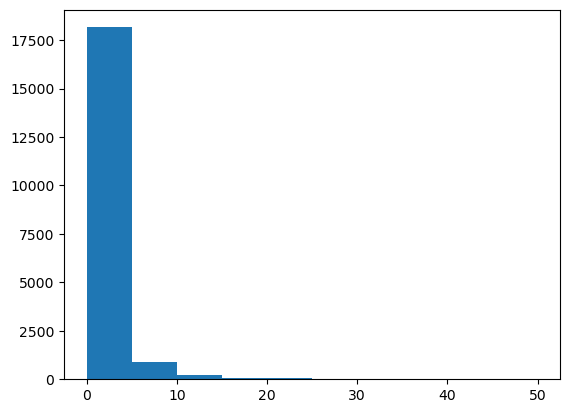

In [55]:
contrib_len = []

for contributor in df['contributors']:
    contrib_len.append(len(contributor))

print("Maximum Contributors: ", max(contrib_len))
print("Average Contributors: ", np.mean(contrib_len))

plt.hist(contrib_len)
plt.show()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19491 entries, 0 to 19490
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   oclcNumber              19491 non-null  object
 1   title                   19491 non-null  object
 2   titleInfo               19491 non-null  object
 3   creator                 19491 non-null  object
 4   contributors            19491 non-null  object
 5   contributors_rom        19491 non-null  object
 6   contributors_lang       19491 non-null  object
 7   contributors_text_dir   19491 non-null  object
 8   contributors_nonperson  19491 non-null  object
 9   isPrimary               19491 non-null  object
 10  relatorCodes            19491 non-null  object
 11  date                    19491 non-null  object
 12  machineReadableDate     19491 non-null  object
 13  language                19491 non-null  object
 14  generalFormat           19491 non-null  object
 15  sp

In [57]:
df['holdsItem'].value_counts()

holdsItem
True    19491
Name: count, dtype: int64

In [58]:
df['peerReviewed'].value_counts()

peerReviewed
N    19491
Name: count, dtype: int64

In [59]:
df['generalFormat'].value_counts()

generalFormat
Book         17487
Video          920
Jrnl           581
Music          388
CompFile        63
AudioBook       31
MsScr            7
Web              7
News             2
Archv            2
Game             1
Image            1
Map              1
Name: count, dtype: int64

In [60]:
df['specificFormat'].value_counts()

specificFormat
Digital      18355
PrintBook      551
CD             360
thsis          190
                31
DVD              2
Bluray           1
2D               1
Name: count, dtype: int64

### Filtering DataFrames

If you want to look at a subset of the data in a dataframe, you can use brackets and specify a condition. For instance, if you want to see all the items for which there is no "specificFormat" listed, you can enter the following line of code.

In [61]:
df[df['specificFormat'] == '']

,oclcNumber,title,titleInfo,creator,contributors,contributors_rom,contributors_lang,contributors_text_dir,contributors_nonperson,isPrimary,...,series,seriesVolume,edition,doi,filmInfo,id,holdsItem,dateHoldingSet,peerReviewed,citationUrl
322,1376642067,Science and technology policy review and outlook,Science and technology policy review and outlook,Organisation for Economic Co-operation and Dev...,[ ],[ ],[ ],[ ],[Organisation for Economic Co-operation and De...,[False],...,,,,,,5640,True,2024-06-29T23:35:42.000+0000,N,
931,1554316,China monthly review,China monthly review,,[],[],[],[],[],[],...,,,,,,5640,True,2024-06-28T15:03:49.000+0000,N,
1151,1347490075,Supper call,Supper call,Charles Wysocki,"[Charles Wysocki, ]","[ , ]","[ , ]","[ , ]","[, Buffalo Games LLC]","[False, False]",...,Library of things,,,,,5640,True,2024-06-27T23:33:29.000+0000,N,
1877,840593563,"Suite in G for three recorders : descant, treb...","Suite in G for three recorders : descant, treb...",Timothy Moore,[Timothy Moore],[ ],[ ],[ ],[],[True],...,Edition Schott,,,,,5640,True,2024-06-26T17:56:16.000+0000,N,
1879,145125985,The Chinese times,The Chinese times,,[],[],[],[],[],[],...,,,,,,5640,True,2024-06-26T17:10:11.000+0000,N,
1892,1330603030,Slavic and East European journal,Slavic and East European journal,American Association of Teachers of Slavic and...,[ ],[ ],[ ],[ ],[American Association of Teachers of Slavic an...,[False],...,,,,,,5640,True,2024-06-26T13:50:43.000+0000,N,
4927,15184654,Business month,Business month,,[],[],[],[],[],[],...,,,,,,5640,True,2024-06-25T06:35:48.000+0000,N,
5127,12640546,Sinfonia Nr. 5,Sinfonia Nr. 5,Joseph Haydn,"[Joseph Haydn, H. C. Robbins Landon]","[ , ]","[ , ]","[ , ]","[, ]","[True, False]",...,Diletto musicale,,,,,5640,True,2024-06-24T20:27:29.000+0000,N,
11127,16725341,Trios pour le coucher du roy,Trios pour le coucher du roy,Jean-Baptiste Lully,"[Jean-Baptiste Lully, Marin Marais, Herbert Sc...","[ , , , ]","[ , , , ]","[ , , , ]","[, , , ]","[True, False, False, False]",...,Pupitre,,,,,5640,True,2024-06-18T23:31:09.000+0000,N,
13427,1105688,Nocturnes for the piano,Nocturnes for the piano,Frédéric Chopin,"[Frédéric Chopin, Rafael Joseffy, James Hune...","[ , , ]","[ , , ]","[ , , ]","[, , ]","[True, False, False]",...,Schirmer's library of musical classics,,,,,5640,True,2024-06-17T20:27:25.000+0000,N,


You can also combine conditions using the following syntax (multiple conditions are put in parentheses, `&` and `|` are used for boolean `and` and `or`):

In [62]:
len(df[(df['generalFormat'] == 'Book') & (df['specificFormat'] == 'Digital')])

16746

In [63]:
df['publisher'].value_counts()

publisher
Columbia University Press       2084
De Gruyter                       986
Springer                         681
Elsevier                         616
Taylor & Francis Group           519
                                ... 
TEXAS A & M UNIV PRESS             1
ForeEdge                           1
Blackbooks                         1
M.E. Sharpe, Credo Reference       1
Tribune Association                1
Name: count, Length: 3029, dtype: int64

In [64]:
type_list = [
    'archv', 'artchapter', 'audiobook', 'book', 'compfile',
    'encyc', 'game', 'image', 'intmm', 'jrnl', 'kit', 'map',
    'msscr', 'music', 'news', 'object', 'snd', 'toy', 'video',
    'vis', 'web'
]

Possible item types: archv, artchapter, audiobook, book, compfile, encyc, game, image, intmm, jrnl, kit, map, msscr, music, news, object, snd, toy, video, vis, web

In [65]:
script_finished = datetime.today().strftime('%H:%M:%S')
script_finished

'11:44:27'

#  EXPORT

Remember that `xlsxwriter` module we installed at the very beginning? This is where it finally comes in... it extends pandas's native export capabilities and allows us to export the contents of a DataFrame to a Microsoft Excel file. If you want to work with data from the OCLC API but you *don't* want to do a whole lot of programming in Python (or if you need to physically print out the data on paper) this is one way to do that.

### String Formatting

Before we do that, though, for those who *do* want to learn more Python, we should discuss string formatting. We will be adapting the name of our output file based on the date range, so that we won't overwrite previous exports every time we run the script.

There are several ways to format strings in Python. Earlier, we concatenated strings using the + operator for our URL, but that can be pretty tedious sometimes.

Three other quick ways to format strings include `%s` formatting, a special kind of string called an f-string, and the `.format()` string method.

In [66]:
filename ='OCLC_New_Titles_%s_to_%s.xlsx' %(start_date, end_date)

print(filename)

filename = f'OCLC_New_Titles_{start_date}_to_{end_date}.xlsx'

print(filename)

filename ='OCLC_New_Titles_{}_to_{}.xlsx'.format(start_date, end_date)

print(filename)

OCLC_New_Titles_2024-06-01_to_2024-06-30.xlsx
OCLC_New_Titles_2024-06-01_to_2024-06-30.xlsx
OCLC_New_Titles_2024-06-01_to_2024-06-30.xlsx


In [67]:
df.to_excel(filename)

Don't be alarmed if you get an error message when opening the Excel file. There is some issue with cell formatting with the citation links. Unfortunately, Microsoft doesn't go into any detail. Click "Yes" in the dialog box.

![title](ErrorMessage.png)

## Data Loss/Reformatting During Storage

When writing a dataframe to an output file, the data type of that output file can affect how data gets stored in it. While Excel files are a good option in terms of being readable by humans, there are some limitations with the format. Unlike JSON data, which can be nested as much as necessary, Excel files can't store data that way. When a column containing Python container objects is saved to an excel (or csv) file, it is interpreted not as that object, but as the literal string, brackets and braces included. 

Becuase of this, if you want to preserve the data as you originally received it, it's sometimes better to export it as a JSON file.

Pandas supports [many alternative formats](https://pandas.pydata.org/pandas-docs/stable/reference/io.html) for import/export.

To illustrate the differences between formats for exported data, we can save our dataframe as a JSON file in addition to an Excel file, then reimport both versions and compare them.

In [68]:
df.to_json('OCLC_New_Titles_2024-06-01_to_2024-06-30.json')

In [69]:
excel_df = pd.read_excel('OCLC_New_Titles_2024-06-01_to_2024-06-30.xlsx', index_col=0)
excel_df.head()

,oclcNumber,title,titleInfo,creator,contributors,contributors_rom,contributors_lang,contributors_text_dir,contributors_nonperson,isPrimary,...,series,seriesVolume,edition,doi,filmInfo,id,holdsItem,dateHoldingSet,peerReviewed,citationUrl
0,1085293558,The statutes of Illinois : embracing all of th...,The statutes of Illinois : embracing all of th...,Illinois,"[' ', 'Samuel Hubbel Treat', 'Walter B. Scates...","[' ', ' ', ' ', ' ', ' ']","[' ', ' ', ' ', ' ', ' ']","[' ', ' ', ' ', ' ', ' ']","['Illinois', '', '', '', 'Illinois Supreme Cou...","[True, False, False, False, False]",...,NaN,NaN,NaN,NaN,NaN,5640,True,2024-06-30T20:23:16.000+0000,N,http://books.google.com/books?id=-FnPtrU-_EAC
1,894240244,La vue,La vue,Raymond Roussel,['Raymond Roussel'],[' '],[' '],[' '],[''],[True],...,NaN,NaN,NaN,NaN,NaN,5640,True,2024-06-30T19:57:10.000+0000,N,http://catalog.hathitrust.org/api/volumes/oclc...
2,1412739922,A compilation of the statutes of the state of ...,A compilation of the statutes of the state of ...,Illinois,"[' ', 'N. H. Purple', ' ']","[' ', ' ', ' ']","[' ', ' ', ' ']","[' ', ' ', ' ']","['Illinois', '', 'Illinois Supreme Court']","[True, False, False]",...,NaN,NaN,NaN,NaN,NaN,5640,True,2024-06-30T19:33:43.000+0000,N,http://catalog.hathitrust.org/api/volumes/oclc...
3,1442973338,Neo-Ottomanism and the politics of emotions in...,Neo-Ottomanism and the politics of emotions in...,Nagehan Tokdoğan,['Nagehan Tokdoğan'],[' '],[' '],[' '],[''],[True],...,Palgrave studies in political psychology,NaN,NaN,10.1007/978-3-031-48723-1,NaN,5640,True,2024-06-30T16:28:21.000+0000,N,https://doi.org/10.1007/978-3-031-48723-1
4,1442999243,Natalia Ginzburg's global legacies,Natalia Ginzburg's global legacies,Stiliana Milkova Rousseva,"['Stiliana Milkova Rousseva', 'Saskia Elizabet...","[' ', ' ']","[' ', ' ']","[' ', ' ']","['', '']","[False, False]",...,Italian and Italian American studies,NaN,NaN,10.1007/978-3-031-49907-4,NaN,5640,True,2024-06-30T16:26:06.000+0000,N,https://doi.org/10.1007/978-3-031-49907-4


In [70]:
json_df = pd.read_json('OCLC_New_Titles_2024-06-01_to_2024-06-30.json')
json_df.head()

C:\Users\davidm\AppData\Local\Temp\ipykernel_22292\2026307533.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_df = pd.read_json('OCLC_New_Titles_2024-06-01_to_2024-06-30.json')
C:\Users\davidm\AppData\Local\Temp\ipykernel_22292\2026307533.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_df = pd.read_json('OCLC_New_Titles_2024-06-01_to_2024-06-30.json')
C:\Users\davidm\AppData\Local\Temp\ipykernel_22292\2026307533.py:1: FutureWarning: The behavior of 'to_datetime' w

,oclcNumber,title,titleInfo,creator,contributors,contributors_rom,contributors_lang,contributors_text_dir,contributors_nonperson,isPrimary,...,series,seriesVolume,edition,doi,filmInfo,id,holdsItem,dateHoldingSet,peerReviewed,citationUrl
0,1085293558,The statutes of Illinois : embracing all of th...,The statutes of Illinois : embracing all of th...,Illinois,"[ , Samuel Hubbel Treat, Walter B. Scates, Rob...","[ , , , , ]","[ , , , , ]","[ , , , , ]","[Illinois, , , , Illinois Supreme Court]","[True, False, False, False, False]",...,,,,,,5640,True,2024-06-30T20:23:16.000+0000,N,http://books.google.com/books?id=-FnPtrU-_EAC
1,894240244,La vue,La vue,Raymond Roussel,[Raymond Roussel],[ ],[ ],[ ],[],[True],...,,,,,,5640,True,2024-06-30T19:57:10.000+0000,N,http://catalog.hathitrust.org/api/volumes/oclc...
2,1412739922,A compilation of the statutes of the state of ...,A compilation of the statutes of the state of ...,Illinois,"[ , N. H. Purple, ]","[ , , ]","[ , , ]","[ , , ]","[Illinois, , Illinois Supreme Court]","[True, False, False]",...,,,,,,5640,True,2024-06-30T19:33:43.000+0000,N,http://catalog.hathitrust.org/api/volumes/oclc...
3,1442973338,Neo-Ottomanism and the politics of emotions in...,Neo-Ottomanism and the politics of emotions in...,Nagehan Tokdoğan,[Nagehan Tokdoğan],[ ],[ ],[ ],[],[True],...,Palgrave studies in political psychology,,,10.1007/978-3-031-48723-1,,5640,True,2024-06-30T16:28:21.000+0000,N,https://doi.org/10.1007/978-3-031-48723-1
4,1442999243,Natalia Ginzburg's global legacies,Natalia Ginzburg's global legacies,Stiliana Milkova Rousseva,"[Stiliana Milkova Rousseva, Saskia Elizabeth Z...","[ , ]","[ , ]","[ , ]","[, ]","[False, False]",...,Italian and Italian American studies,,,10.1007/978-3-031-49907-4,,5640,True,2024-06-30T16:26:06.000+0000,N,https://doi.org/10.1007/978-3-031-49907-4


In [71]:
df.head()

,oclcNumber,title,titleInfo,creator,contributors,contributors_rom,contributors_lang,contributors_text_dir,contributors_nonperson,isPrimary,...,series,seriesVolume,edition,doi,filmInfo,id,holdsItem,dateHoldingSet,peerReviewed,citationUrl
0,1085293558,The statutes of Illinois : embracing all of th...,The statutes of Illinois : embracing all of th...,Illinois,"[ , Samuel Hubbel Treat, Walter B. Scates, Rob...","[ , , , , ]","[ , , , , ]","[ , , , , ]","[Illinois, , , , Illinois Supreme Court]","[True, False, False, False, False]",...,,,,,,5640,True,2024-06-30T20:23:16.000+0000,N,http://books.google.com/books?id=-FnPtrU-_EAC
1,894240244,La vue,La vue,Raymond Roussel,[Raymond Roussel],[ ],[ ],[ ],[],[True],...,,,,,,5640,True,2024-06-30T19:57:10.000+0000,N,http://catalog.hathitrust.org/api/volumes/oclc...
2,1412739922,A compilation of the statutes of the state of ...,A compilation of the statutes of the state of ...,Illinois,"[ , N. H. Purple, ]","[ , , ]","[ , , ]","[ , , ]","[Illinois, , Illinois Supreme Court]","[True, False, False]",...,,,,,,5640,True,2024-06-30T19:33:43.000+0000,N,http://catalog.hathitrust.org/api/volumes/oclc...
3,1442973338,Neo-Ottomanism and the politics of emotions in...,Neo-Ottomanism and the politics of emotions in...,Nagehan Tokdoğan,[Nagehan Tokdoğan],[ ],[ ],[ ],[],[True],...,Palgrave studies in political psychology,,,10.1007/978-3-031-48723-1,,5640,True,2024-06-30T16:28:21.000+0000,N,https://doi.org/10.1007/978-3-031-48723-1
4,1442999243,Natalia Ginzburg's global legacies,Natalia Ginzburg's global legacies,Stiliana Milkova Rousseva,"[Stiliana Milkova Rousseva, Saskia Elizabeth Z...","[ , ]","[ , ]","[ , ]","[, ]","[False, False]",...,Italian and Italian American studies,,,10.1007/978-3-031-49907-4,,5640,True,2024-06-30T16:26:06.000+0000,N,https://doi.org/10.1007/978-3-031-49907-4


If we look at the "contributors_rom" field for each dataframe, we can see that the excel version has saved our list as a string, whereas the JSON version has preserved the original list as an array.

In [72]:
type(excel_df.iloc[0]['contributors_rom'])

str

In [73]:
excel_df.iloc[0]['contributors_rom']

"[' ', ' ', ' ', ' ', ' ']"

In [74]:
type(json_df.iloc[0]['contributors_rom'])

list

In [75]:
json_df.iloc[0]['contributors_rom']

[' ', ' ', ' ', ' ', ' ']

In [76]:
df.equals(json_df)

False

In [77]:
df.equals(excel_df)

False

We can use the `.equals()` method on each column individually to determine what data has been changed during the export process.

In [78]:
for column in df.columns:
    print(df[column].equals(excel_df[column]), column)

False oclcNumber
True title
True titleInfo
False creator
False contributors
False contributors_rom
False contributors_lang
False contributors_text_dir
False contributors_nonperson
False isPrimary
False relatorCodes
True date
True machineReadableDate
True language
True generalFormat
False specificFormat
False publisher
False publicationPlace
False isbns
False subjectsText
False summariesText
False series
False seriesVolume
False edition
False doi
False filmInfo
False id
True holdsItem
True dateHoldingSet
True peerReviewed
False citationUrl


In [79]:
for column in df.columns:
    print(df[column].equals(json_df[column]), column)

False oclcNumber
True title
True titleInfo
True creator
True contributors
True contributors_rom
True contributors_lang
True contributors_text_dir
True contributors_nonperson
True isPrimary
True relatorCodes
True date
True machineReadableDate
True language
True generalFormat
True specificFormat
True publisher
True publicationPlace
True isbns
True subjectsText
True summariesText
True series
True seriesVolume
True edition
True doi
True filmInfo
False id
True holdsItem
True dateHoldingSet
True peerReviewed
True citationUrl


In [80]:
df['oclcNumber']

0        1085293558
1         894240244
2        1412739922
3        1442973338
4        1442999243
            ...    
19486      14987479
19487        690729
19488        644573
19489     235799606
19490       3461591
Name: oclcNumber, Length: 19491, dtype: object

In [81]:
json_df['oclcNumber']

0        1085293558
1         894240244
2        1412739922
3        1442973338
4        1442999243
            ...    
19486      14987479
19487        690729
19488        644573
19489     235799606
19490       3461591
Name: oclcNumber, Length: 19491, dtype: int64

Exporting as JSON and reimporting has caused the data type of columns with only integers (oclcNumber and id, which were originally read in as strings) to change to int64.

Other than that, all the data is identical.

## Lambda Functions and the .apply() Method

In most contexts in computing, a "lambda" function refers to an anonymous function (literally, one that doesn't have a name). In conjunction with the `.apply()` method in a pandas DataFrame, lambda functions may be used to quickly apply a function or a method to every element in a column.

In this case, we're going to convert the original DataFrame's oclcNumber and id columns to int format, to make sure we haven't actually lost any data when exporting to a JSON file.

You don't always need to use lambda inside the apply method, but it can make it easier to use certain functions, especially if they require additional arguments.

In [82]:
df['oclcNumber'] = df['oclcNumber'].apply(lambda x: int(x))
df['id'] = df['id'].apply(lambda x: int(x))

In [83]:
df.equals(json_df)

True

# What's Next?

Now that you've seen how this script works start-to-finish, take a closer look at the API documentation.

What else can you think of that could be gleaned from the New Titles API?

What about the [WorldCat Discovery API](https://developer.api.oclc.org/worldcat-discovery)? Or [Suggestions](https://developer.api.oclc.org/suggestions-api)? Or the [WMS Availability](https://developer.api.oclc.org/wms-availability) API?

What do *you* use OCLC for? How might your use of that feature be improved by using an API?

What would you like to see for future Python workshops?

# Acknowledgements

Special thanks to Candace Lebel for writing the original script this notebook was based on!